# Лабораторная работа №1

Имортируем библиотеки

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

Загружаем временной ряд с ценами активов Газпрома 

In [18]:
data = pd.read_csv("GAZP_240825_240925.csv",parse_dates=['<DATE>'],delimiter=";",date_format="%y%m%d")
data['date_time'] = data['<DATE>'].astype(str)+"-"+data['<TIME>'].astype(str)
data.set_index(data['date_time'],inplace=True)
print(data)

                  <TICKER>  <PER>     <DATE>  <TIME>  <OPEN>  <HIGH>   <LOW>  \
date_time                                                                      
2024-08-26-100000     GAZP      5 2024-08-26  100000  119.50  120.67  119.49   
2024-08-26-100500     GAZP      5 2024-08-26  100500  120.54  121.00  120.12   
2024-08-26-101000     GAZP      5 2024-08-26  101000  120.27  120.58  120.03   
2024-08-26-101500     GAZP      5 2024-08-26  101500  120.42  120.84  120.28   
2024-08-26-102000     GAZP      5 2024-08-26  102000  120.32  120.52  119.76   
...                    ...    ...        ...     ...     ...     ...     ...   
2024-09-25-100500     GAZP      5 2024-09-25  100500  139.11  139.21  138.42   
2024-09-25-101000     GAZP      5 2024-09-25  101000  138.92  138.92  138.20   
2024-09-25-101500     GAZP      5 2024-09-25  101500  138.64  138.76  138.10   
2024-09-25-102000     GAZP      5 2024-09-25  102000  138.14  138.73  138.12   
2024-09-25-102500     GAZP      5 2024-0

Строим график временного ряда.

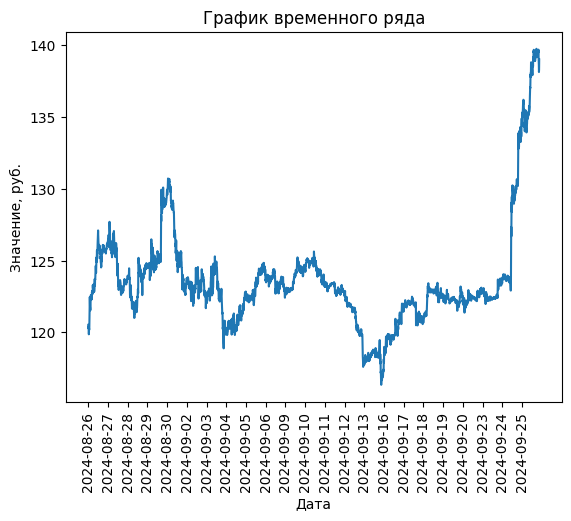

In [19]:
plt.plot(data.index,data["<CLOSE>"])
plt.xlabel("Дата")
plt.ylabel("Значение, руб.")
plt.xticks(np.arange(start=0,stop=3600,step=157),labels=pd.unique(data['<DATE>'].astype(str)),rotation=90)
plt.title("График временного ряда")
plt.show()

На графике видно, что большую часть времени цена была около 122 рублей, но в последний день цена выросла до 140 рублей. На основе этого можно сказать, что цена вероятно вновь вернётся к цене около 122 рублей.

Построим скользящее среднее для временного ряда со скользящим окном 50, 100, 300, 500.

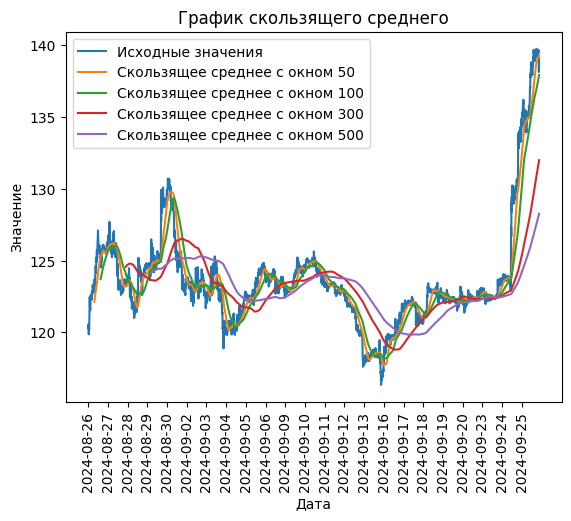

In [20]:
rolling_mean_5 = data["<CLOSE>"].rolling(window=50).mean()
rolling_mean_10 = data["<CLOSE>"].rolling(window=100).mean()
rolling_mean_30 = data["<CLOSE>"].rolling(window=300).mean()
rolling_mean_50 = data["<CLOSE>"].rolling(window=500).mean()
plt.plot(data.index, data["<CLOSE>"], label="Исходные значения")
plt.plot(data.index, rolling_mean_5, label="Скользящее среднее с окном 50")
plt.plot(data.index, rolling_mean_10, label="Скользящее среднее с окном 100")
plt.plot(data.index, rolling_mean_30, label="Скользящее среднее с окном 300")
plt.plot(data.index, rolling_mean_50, label="Скользящее среднее с окном 500")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.title("График скользящего среднего")
plt.xticks(np.arange(start=0,stop=3600,step=157),labels=pd.unique(data['<DATE>'].astype(str)),rotation=90)
plt.legend()
plt.show()

Благодаря скользящему окну можно увидеть график без учёта резких колебаний и оценить общую динамику. Видно, что цена колеблтся в диапазоне от 120 до 125 рублей.

Построим экспоненциальное скользящее среднее для временного ряда со скользящим окном 50, 100, 300, 500.

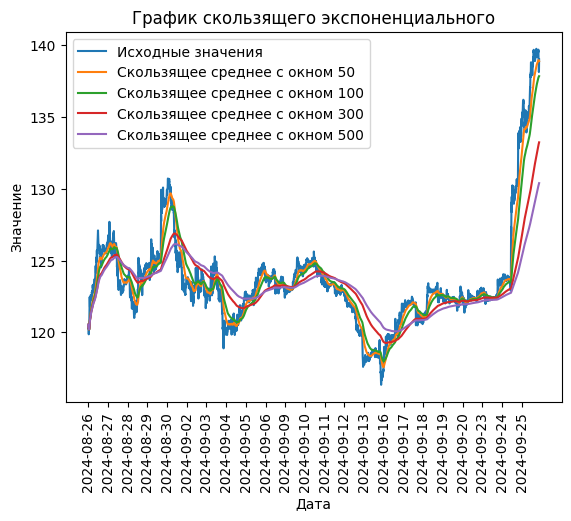

In [28]:
exp_rolling_mean_5 = data["<CLOSE>"].ewm(span=50).mean()
exp_rolling_mean_10 = data["<CLOSE>"].ewm(span=100).mean()
exp_rolling_mean_30 = data["<CLOSE>"].ewm(span=300).mean()
exp_rolling_mean_50 = data["<CLOSE>"].ewm(span=500).mean()
plt.plot(data.index, data["<CLOSE>"], label="Исходные значения")
plt.plot(data.index, exp_rolling_mean_5, label="Скользящее среднее с окном 50")
plt.plot(data.index, exp_rolling_mean_10, label="Скользящее среднее с окном 100")
plt.plot(data.index, exp_rolling_mean_30, label="Скользящее среднее с окном 300")
plt.plot(data.index, exp_rolling_mean_50, label="Скользящее среднее с окном 500")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.xticks(np.arange(start=0,stop=3600,step=157),labels=pd.unique(data['<DATE>'].astype(str)),rotation=90)
plt.title("График скользящего экспоненциального")
plt.legend()
plt.show()

Благодаря экспоненциальному скользящему окну можно увидеть график без учёта резких колебаний, но с большей повторяемостью изначального графика. Видно, что цена колеблтся в диапазоне от 120 до 125 рублей.

Сделаем прогноз движения актива на основе экспоненциального скользящего среденго на 500 периодов вперёд. Для этого сгенерируем 500 следующих дат и значения для них на основе 500 последниъ значений экспоненциального скользящего среднего.

In [22]:
windows_size = 500
rolling_mean = data["<CLOSE>"].rolling(window=windows_size).mean()
last_known_date = data["<DATE>"].iloc[-1]
times = data['<TIME>'].unique()
future_dates = []
future_days=[]
generated_dates=0
day_offset=1
while True:
    for j in times:
        future_days.append(str(last_known_date+pd.DateOffset(day_offset))[:10])
        future_dates.append(str(last_known_date+pd.DateOffset(day_offset))[:10]+"-"+str(j))
        generated_dates+=1
        if generated_dates>=windows_size:
            break
    if generated_dates>=windows_size:
        break
    day_offset+=1
future_sma = []
last_values = data['<CLOSE>'][-windows_size:].tolist()
for i in range(windows_size):
    future_value = np.mean(last_values)
    future_sma.append(future_value)
    last_values.pop(0)
    last_values.append(future_value)
future_df = pd.DataFrame(data=future_sma, index=future_dates, columns=['Forecast'])
combined_df = pd.concat([data, future_df])

Построим график для сделанного прогноза, где синим отображен основной график, красным - экспоненциальное скользящее среднее, а зелёным сам прогноз.

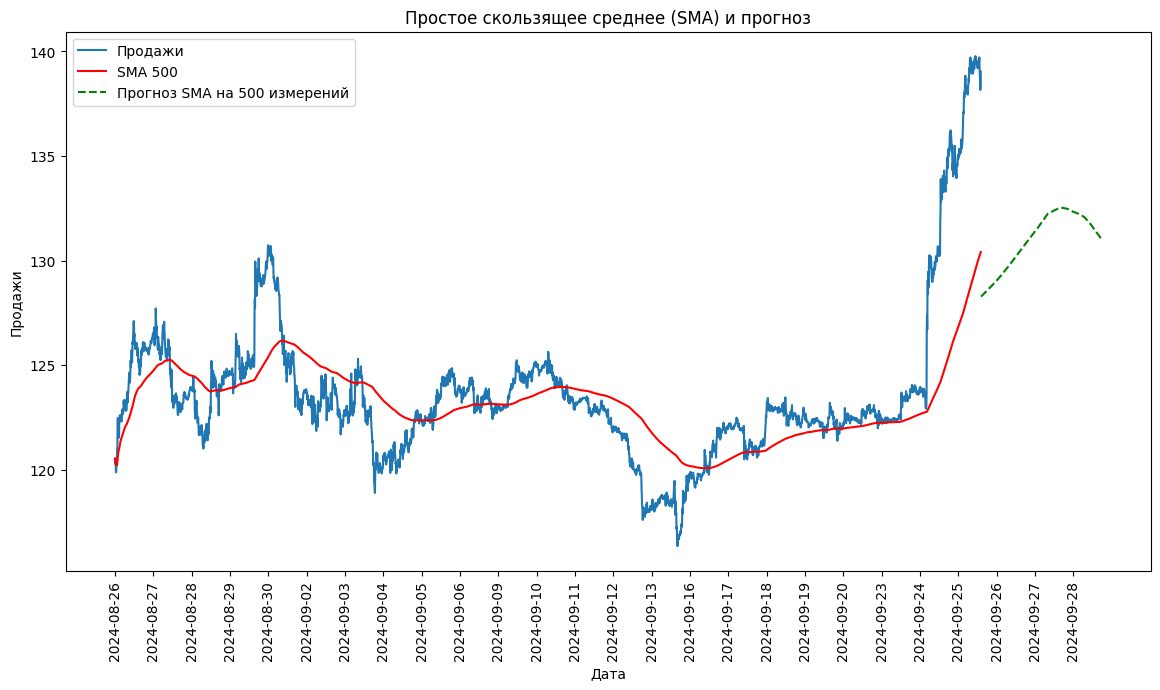

In [27]:
plt.figure(figsize=(14, 7))
label_dates=pd.Series(data['<DATE>'].copy())
for i in future_dates:
    label_dates[i] = i[:10]
plt.xticks(np.arange(start=0,stop=3600+windows_size,step=159),labels=pd.unique((label_dates).astype(str))[:-1],rotation=90)
plt.plot(data['<CLOSE>'], label='Продажи')
plt.plot(rolling_mean_50, label=f'SMA {windows_size}', color='red')
plt.plot(future_df, label=f'Прогноз SMA на {windows_size} измерений', color='green', linestyle='dashed')
plt.title('Простое скользящее среднее (SMA) и прогноз')
plt.xlabel('Дата')

plt.ylabel('Продажи')
plt.legend()
plt.show()

## Вывод

В результате проделанной работы был получен прогноз движения стоимости актива на следующие 3 дня. Согласно прогнозу стоимость актива будет держаться в районе 130 рублей.